In [56]:
import pandas as pd
import numpy as np
from keras.utils import np_utils, load_img
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras_vggface.vggface import VGGFace
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D

In [57]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [58]:
main_folder = 'input/adiencedb/inside/'
images_folder = main_folder + 'faces/'
weights_folder = 'weights/'

IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
K_FOLD = 5

In [59]:
df_0 = pd.read_csv((main_folder + "fold_0_data.txt"), sep="\t")
df_1 = pd.read_csv((main_folder + "fold_1_data.txt"), sep="\t")
df_2 = pd.read_csv((main_folder + "fold_2_data.txt"), sep="\t")
df_3 = pd.read_csv((main_folder + "fold_3_data.txt"), sep="\t")
df_4 = pd.read_csv((main_folder + "fold_4_data.txt"), sep="\t")
df_4

,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score
0,115321157@N03,12111738395_a7f715aa4e_o.jpg,1744,"(4, 6)",m,663,997,637,638,-95,0,129
1,115321157@N03,12112413505_0aea8e17c6_o.jpg,1745,"(48, 53)",m,505,846,433,433,-95,0,72
2,115321157@N03,12112392255_995532c2f0_o.jpg,1744,"(4, 6)",m,517,1185,383,383,0,0,70
3,115321157@N03,12112392255_995532c2f0_o.jpg,1746,"(25, 32)",m,2247,688,376,376,0,30,67
4,115321157@N03,12112392255_995532c2f0_o.jpg,1747,"(25, 32)",m,1421,667,325,325,0,0,102
...,...,...,...,...,...,...,...,...,...,...,...,...
3811,7153718@N04,11598838386_349a0d4849_o.jpg,2282,None,NaN,596,460,1472,1473,-75,0,30
3812,7153718@N04,11598166203_c70bb34c80_o.jpg,2283,None,NaN,1179,755,331,331,5,0,108
3813,7153718@N04,11598166203_c70bb34c80_o.jpg,2282,None,NaN,1201,1179,293,293,5,0,99
3814,7153718@N04,11598145163_733cb99713_o.jpg,2282,None,NaN,1027,946,408,408,-85,0,49


## Data Preprocessing

In [60]:
df_0.dropna(inplace=True)
df_1.dropna(inplace=True)
df_2.dropna(inplace=True)
df_3.dropna(inplace=True)
df_4.dropna(inplace=True)

df_0['user_id'] = df_0['user_id'] + r'/coarse_tilt_aligned_face.' + df_0['face_id'].astype(str) + '.' + df_0["original_image"]
df_1['user_id'] = df_1['user_id'] + r'/coarse_tilt_aligned_face.' + df_1['face_id'].astype(str) + '.' + df_1["original_image"]
df_2['user_id'] = df_2['user_id'] + r'/coarse_tilt_aligned_face.' + df_2['face_id'].astype(str) + '.' + df_2["original_image"]
df_3['user_id'] = df_3['user_id'] + r'/coarse_tilt_aligned_face.' + df_3['face_id'].astype(str) + '.' + df_3["original_image"]
df_4['user_id'] = df_4['user_id'] + r'/coarse_tilt_aligned_face.' + df_4['face_id'].astype(str) + '.' + df_4["original_image"]

df_0.reset_index(inplace=True)
df_1.reset_index(inplace=True)
df_2.reset_index(inplace=True)
df_3.reset_index(inplace=True)
df_4.reset_index(inplace=True)

df_0 = df_0[df_0.age != "None"]
df_1 = df_1[df_1.age != "None"]
df_2 = df_2[df_2.age != "None"]
df_3 = df_3[df_3.age != "None"]
df_4 = df_4[df_4.age != "None"]

df_0 = df_0[df_0.gender != "u"]
df_1 = df_1[df_1.gender != "u"]
df_2 = df_2[df_2.gender != "u"]
df_3 = df_3[df_3.gender != "u"]
df_4 = df_4[df_4.gender != "u"]

df_4

,index,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score
0,0,115321157@N03/coarse_tilt_aligned_face.1744.12...,12111738395_a7f715aa4e_o.jpg,1744,"(4, 6)",m,663,997,637,638,-95,0,129
1,1,115321157@N03/coarse_tilt_aligned_face.1745.12...,12112413505_0aea8e17c6_o.jpg,1745,"(48, 53)",m,505,846,433,433,-95,0,72
2,2,115321157@N03/coarse_tilt_aligned_face.1744.12...,12112392255_995532c2f0_o.jpg,1744,"(4, 6)",m,517,1185,383,383,0,0,70
3,3,115321157@N03/coarse_tilt_aligned_face.1746.12...,12112392255_995532c2f0_o.jpg,1746,"(25, 32)",m,2247,688,376,376,0,30,67
4,4,115321157@N03/coarse_tilt_aligned_face.1747.12...,12112392255_995532c2f0_o.jpg,1747,"(25, 32)",m,1421,667,325,325,0,0,102
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3726,3787,101515718@N03/coarse_tilt_aligned_face.2280.10...,10587826073_6663f5b654_o.jpg,2280,"(25, 32)",f,718,748,492,492,0,0,63
3727,3788,101515718@N03/coarse_tilt_aligned_face.2278.10...,10587571495_a61785cd06_o.jpg,2278,"(25, 32)",m,48,472,768,768,-15,0,25
3728,3789,101515718@N03/coarse_tilt_aligned_face.2279.10...,10587571495_a61785cd06_o.jpg,2279,"(25, 32)",f,950,0,692,687,-5,0,27
3729,3790,50458575@N08/coarse_tilt_aligned_face.2281.942...,9426695459_9e8b347604_o.jpg,2281,"(25, 32)",f,831,895,899,899,0,15,59


In [61]:
folds = [df_0, df_1, df_2, df_3, df_4]
df_train = pd.DataFrame()
for sel_fold in range(len(folds)):
    df_train = pd.concat([df_train,folds[sel_fold]])

(25, 32)
(38, 43)
(4, 6)
(60, 100)
(15, 20)
(48, 53)
(8, 12)
(0, 2)
(38, 48)
35
3
55
58
22
13
45
36
23
(38, 42)
(8, 23)
(27, 32)
57
2
29
34
42
46


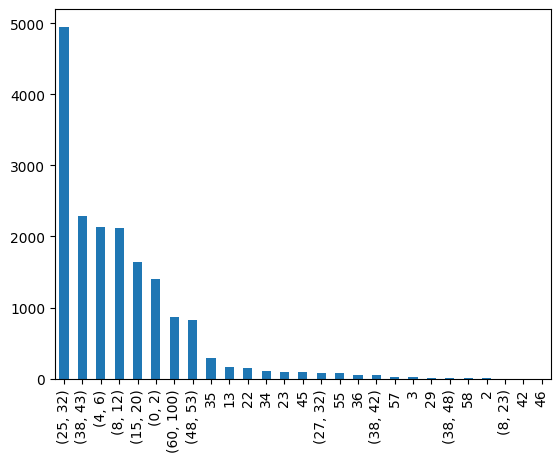

In [62]:
df_train = df_train[df_train.age != "None"]

df_train['age'].value_counts().plot(kind='bar')

x = df_train['age'].unique()
num =0
for i in x:
#     print(f"df_train.loc[(df_train.age == '{i}'),'age']='{num}'")
    num+=1
    print(i)
    


In [63]:
def consolidate_age(df_train):
    
    df_train.loc[(df_train.age == '(38, 42)'),'age']='(38, 43)'
    df_train.loc[(df_train.age == '(8, 12)'),'age']='(8, 23)'
    df_train.loc[(df_train.age == '(15, 20)'),'age']='(8, 23)'
    df_train.loc[(df_train.age == '(27, 32)'),'age']='(25, 32)'

    df_train.loc[(df_train.age == '2'),'age']='(0, 6)'
    df_train.loc[(df_train.age == '3'),'age']='(0, 6)'
    df_train.loc[(df_train.age == '(0, 2)'),'age']='(0, 6)'
    df_train.loc[(df_train.age == '(4, 6)'),'age']='(0, 6)'

    df_train.loc[(df_train.age == '35'),'age']='(34, 36)'
    df_train.loc[(df_train.age == '55'),'age']='(55, 58)'
    df_train.loc[(df_train.age == '58'),'age']='(55, 58)'
    df_train.loc[(df_train.age == '22'),'age']='(8, 23)'
    df_train.loc[(df_train.age == '13'),'age']='(8, 23)'
    df_train.loc[(df_train.age == '45'),'age']='(38, 48)'
    df_train.loc[(df_train.age == '36'),'age']='(34, 36)'
    df_train.loc[(df_train.age == '23'),'age']='(8, 23)'
    df_train.loc[(df_train.age == '57'),'age']='(55, 58)'
    df_train.loc[(df_train.age == '29'),'age']='(25, 32)'
    df_train.loc[(df_train.age == '34'),'age']='(34, 36)'
    df_train.loc[(df_train.age == '42'),'age']='(38, 48)'
    df_train.loc[(df_train.age == '46'),'age']='(38, 48)'

    df_train.loc[(df_train.age == '(38, 43)'),'age']='(38, 48)'
    
    df_train.loc[(df_train.age == '(60, 100)'),'age']=61
    df_train.loc[(df_train.age == '(48, 53)'),'age']=49
    df_train.loc[(df_train.age == '(0, 6)'),'age']=1
    df_train.loc[(df_train.age == '(38, 48)'),'age']=39
    df_train.loc[(df_train.age == '(8, 23)'),'age']=9
    df_train.loc[(df_train.age == '(34, 36)'),'age']=35
    df_train.loc[(df_train.age == '(55, 58)'),'age']=56
    df_train.loc[(df_train.age == '(25, 32)'),'age']=26
    
    df_train.loc[(df_train.gender == 'm'),'gender']="male"
    df_train.loc[(df_train.gender == 'f'),'gender']="female"
    

#     df_train['age'] = np.asarray(df_train['age']).astype(np.float32)
#     df_train['age'] = df_train['age'].astype(np.array)

#     df_train.loc[(df_train.age == df_train.age),'age']=df_train['age'].astype("category")
    
    return df_train

In [64]:


for fold in folds:
    fold = consolidate_age(fold)

In [65]:
# df_0['age'] = np.asarray(df_0['age']).astype(np.float32)
# df_1['age'] = np.asarray(df_1['age']).astype(np.float32)
# df_2['age'] = np.asarray(df_2['age']).astype(np.float32)
# df_3['age'] = np.asarray(df_3['age']).astype(np.float32)
# df_4['age'] = np.asarray(df_4['age']).astype(np.float32)

# df_0['gender'] = np.asarray(df_0['gender']).astype(np.float32)
# df_1['gender'] = np.asarray(df_1['gender']).astype(np.float32)
# df_2['gender'] = np.asarray(df_2['gender']).astype(np.float32)
# df_3['gender'] = np.asarray(df_3['gender']).astype(np.float32)
# df_4['gender'] = np.asarray(df_4['gender']).astype(np.float32)

In [66]:
import tensorflow as tf
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("age")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    return ds


#default divisor value == 1
def embed_categorical_feature(feature, name, dataset, is_string, divisor = 1):
    lookup_class = keras.layers.StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="int") 

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)

    num_categories = lookup.vocabulary_size()
    embedded_feature = tf.keras.layers.Embedding(input_dim = num_categories+1, output_dim = math.floor(num_categories/divisor) )

    embedded_feature = embedded_feature(encoded_feature)
    embedded_feature = layers.Flatten()(embedded_feature)

    return embedded_feature

In [67]:
# age = keras.Input(shape=(1,), name="age", dtype="int64")

# train_ds = dataframe_to_dataset(df_train)

# age_embed = embed_categorical_feature(age, "age", train_ds, True)

In [68]:
# train_ds

In [69]:
import keras

In [70]:
# classes = df_train['age'].unique()

# target = df_train['age'].values
# target_classes = keras.utils.to_categorical(target, classes)

In [71]:
import numpy as np 
import pandas as pd
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# dataset_folder_name = 'UTKFace'

TRAIN_TEST_SPLIT = 0.7
IM_WIDTH = IM_HEIGHT = 198
dataset_dict = {
    'gender': {
        0: 'male',
        1: 'female'
    }
}
dataset_dict['gender_alias'] = dict((g, i) for i, g in dataset_dict['gender'].items())

In [72]:
folds = [df_0, df_1, df_2, df_3, df_4]
df_train = pd.DataFrame()
for sel_fold in range(len(folds)):
    df_train = pd.concat([df_train,folds[sel_fold]])

In [73]:
!pip install plotly

In [74]:
import plotly.graph_objects as go

def plot_distribution(pd_series):
    labels = pd_series.value_counts().index.tolist()
    counts = pd_series.value_counts().values.tolist()
    
    pie_plot = go.Pie(labels=labels, values=counts, hole=.3)
    fig = go.Figure(data=[pie_plot])
    fig.update_layout(title_text='Distribution for %s' % pd_series.name)
    
    fig.show()

In [75]:
df = df_train

In [76]:
plot_distribution(df_train['gender'])

In [77]:
# bins = [8, 25, 34, 38, 48, 55, 60, np.inf]
# names = ['<6', '8-23', '25-32', '34-36', '38-48', '55-58', '60+']

# age_binned = pd.cut(df['age'], bins, labels=names)
# plot_distribution(age_binned)

In [78]:
import plotly.express as px
fig = px.histogram(df, x="age", nbins=20)
fig.update_layout(title_text='Age distribution')
fig.show()

In [79]:
!dir

 Volume in drive C has no label.
 Volume Serial Number is 28AA-B13C

 Directory of C:\Users\Alvin Chan\Desktop\NN_proj_yx2\NN_PROJ

08/11/2022  05:19 PM    <DIR>          .
08/11/2022  05:19 PM    <DIR>          ..
08/11/2022  03:39 PM    <DIR>          .ipynb_checkpoints
08/11/2022  05:17 PM           431,130 adience_gender_pred - Copy.ipynb
08/11/2022  05:19 PM            63,685 adience_gender_pred.ipynb
08/11/2022  10:26 AM            43,955 gender_age_pred.ipynb
04/11/2022  01:53 AM           639,204 gender_pred.ipynb
03/11/2022  12:48 AM     1,443,490,838 img_align_celeba.zip
08/11/2022  11:39 AM    <DIR>          input
08/11/2022  05:17 PM    <DIR>          model_checkpoint
08/11/2022  11:47 AM    <DIR>          test
08/11/2022  11:47 AM    <DIR>          weights
31/10/2022  11:54 PM        71,570,968 weights.best.inc.male.hdf5
               6 File(s)  1,516,239,780 bytes
               7 Dir(s)  92,599,488,512 bytes free


In [80]:
from keras.utils import to_categorical
from PIL import Image

class UtkFaceDataGenerator():
    """
    Data generator for the UTKFace dataset. This class should be used when training our Keras multi-output model.
    """
    def __init__(self, df):
        self.df = df
        
    def generate_split_indexes(self):
        p = np.random.permutation(len(self.df))
        train_up_to = int(len(self.df) * TRAIN_TEST_SPLIT)
        train_idx = p[:train_up_to]
        test_idx = p[train_up_to:]        
        train_up_to = int(train_up_to * TRAIN_TEST_SPLIT)
        train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]
        
        # converts alias to id
        self.df['gender'] = self.df['gender'].map(lambda gender: dataset_dict['gender_alias'][gender])
#         self.df['race_id'] = self.df['race'].map(lambda race: dataset_dict['race_alias'][race])        
        self.max_age = self.df['age'].max()
        
        return train_idx, valid_idx, test_idx
    
    def preprocess_image(self, img_path):
        """
        Used to perform some minor preprocessing on the image before inputting into the network.
        """
        
        rel_path = "input/adiencedb/inside/faces"
        img_path = os.path.join(rel_path,img_path)
        
#         print(img_path)
        im = Image.open(img_path)
        im = im.resize((IM_WIDTH, IM_HEIGHT))
        im = np.array(im) / 255.0
        
        return im
        
    def generate_images(self, image_idx, is_training, batch_size=16):
        """
        Used to generate a batch with images when training/testing/validating our Keras model.
        """
        
        # arrays to store our batched data
#         images, ages, races, genders = [], [], [], []
        images, ages, genders = [], [], []
        while True:
            for idx in image_idx:
                person = self.df.iloc[idx]
                
                age = person['age']
#                 race = person['race_id']
                gender = person['gender']
                file = person['user_id']
                
                im = self.preprocess_image(file)
                
#                 ages.append(age)
                ages.append(age / self.max_age)
#                 races.append(to_categorical(race, len(dataset_dict['race_id'])))
                genders.append(to_categorical(gender, len(dataset_dict['gender'])))
                images.append(im)
                
                # yielding condition
                if len(images) >= batch_size:
                    yield np.array(images), [np.array(ages), np.array(genders)]
#                     yield np.array(images), [np.array(ages), np.array(races), np.array(genders)]
                    images, ages, genders = [], [], []
#                     images, ages, races, genders = [], [], [], []
                    
            if not is_training:
                break
                
data_generator = UtkFaceDataGenerator(df)
train_idx, valid_idx, test_idx = data_generator.generate_split_indexes() 

In [81]:
from keras.models import Model
from tensorflow.keras.layers import BatchNormalization
# from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Lambda
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
import tensorflow as tf

class UtkMultiOutputModel():
    """
    Used to generate our multi-output model. This CNN contains three branches, one for age, other for 
    sex and another for race. Each branch contains a sequence of Convolutional Layers that is defined
    on the make_default_hidden_layers method.
    """
    def make_default_hidden_layers(self, inputs):
        """
        Used to generate a default set of hidden layers. The structure used in this network is defined as:
        
        Conv2D -> BatchNormalization -> Pooling -> Dropout
        """
        x = Conv2D(16, (3, 3), padding="same")(inputs)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(3, 3))(x)
        x = Dropout(0.25)(x)        
        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)        
        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)        
        return x    
    def build_race_branch(self, inputs, num_races):
        """
        Used to build the race branch of our face recognition network.
        This branch is composed of three Conv -> BN -> Pool -> Dropout blocks, 
        followed by the Dense output layer.
        """
        x = self.make_default_hidden_layers(inputs)        
        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(num_races)(x)
        x = Activation("softmax", name="race_output")(x)        
        return x    
    
    def build_gender_branch(self, inputs, num_genders=2):
        """
        Used to build the gender branch of our face recognition network.
        This branch is composed of three Conv -> BN -> Pool -> Dropout blocks, 
        followed by the Dense output layer.
        """
        x = Lambda(lambda c: tf.image.rgb_to_grayscale(c))(inputs)        
        x = self.make_default_hidden_layers(inputs)        
        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(num_genders)(x)
        x = Activation("sigmoid", name="gender_output")(x)        
        return x    
    def build_age_branch(self, inputs):   
        """
        Used to build the age branch of our face recognition network.
        This branch is composed of three Conv -> BN -> Pool -> Dropout blocks, 
        followed by the Dense output layer.        """
        x = self.make_default_hidden_layers(inputs)        
        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(1)(x)
        x = Activation("linear", name="age_output")(x)        
        return x    
    
    def assemble_full_model(self, width, height): # num_races
        """
        Used to assemble our multi-output model CNN.
        """
        input_shape = (height, width, 3)#3)        
        inputs = Input(shape=input_shape)        
        age_branch = self.build_age_branch(inputs)
#         race_branch = self.build_race_branch(inputs, num_races)
        gender_branch = self.build_gender_branch(inputs)        
        model = Model(inputs=inputs,
                     outputs = [age_branch, gender_branch], # race_branch, 
                     name="face_net")        
        return model
    
model = UtkMultiOutputModel().assemble_full_model(IM_WIDTH, IM_HEIGHT) #, num_races=len(dataset_dict['race_alias']))

In [82]:
from keras.optimizers import Adam

init_lr = 1e-4
epochs = 100

opt = Adam(learning_rate=init_lr, decay=init_lr / epochs)

model.compile(optimizer=opt, 
              loss={
                  'age_output': 'mse', 
#                   'race_output': 'categorical_crossentropy', 
                  'gender_output': 'binary_crossentropy'},
              loss_weights={
                  'age_output': 4., 
#                   'race_output': 1.5, 
                  'gender_output': 0.1},
              metrics={
                  'age_output': 'mae', 
#                   'race_output': 'accuracy',
                  'gender_output': 'accuracy'})

In [83]:
from keras.callbacks import ModelCheckpoint

batch_size = 32
valid_batch_size = 32
train_gen = data_generator.generate_images(train_idx, is_training=True, batch_size=batch_size)
valid_gen = data_generator.generate_images(valid_idx, is_training=True, batch_size=valid_batch_size)

callbacks = [
    ModelCheckpoint("./model_checkpoint", monitor='val_loss')
]


history = model.fit(train_gen,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=epochs,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=len(valid_idx)//valid_batch_size)

Epoch 1/100
267/267 [==============================] - ETA: 0s - loss: 11.9824 - age_output_loss: 2.9753 - gender_output_loss: 0.8128 - age_output_mae: 1.3531 - gender_output_accuracy: 0.6362

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 196s 726ms/step - loss: 11.9824 - age_output_loss: 2.9753 - gender_output_loss: 0.8128 - age_output_mae: 1.3531 - gender_output_accuracy: 0.6362 - val_loss: 24.8687 - val_age_output_loss: 6.1990 - val_gender_output_loss: 0.7278 - val_age_output_mae: 2.4570 - val_gender_output_accuracy: 0.5436
Epoch 2/100
267/267 [==============================] - ETA: 0s - loss: 7.9574 - age_output_loss: 1.9722 - gender_output_loss: 0.6875 - age_output_mae: 1.0927 - gender_output_accuracy: 0.6875

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 194s 729ms/step - loss: 7.9574 - age_output_loss: 1.9722 - gender_output_loss: 0.6875 - age_output_mae: 1.0927 - gender_output_accuracy: 0.6875 - val_loss: 79.0873 - val_age_output_loss: 19.7419 - val_gender_output_loss: 1.1972 - val_age_output_mae: 3.7277 - val_gender_output_accuracy: 0.6039
Epoch 3/100
267/267 [==============================] - ETA: 0s - loss: 6.3196 - age_output_loss: 1.5640 - gender_output_loss: 0.6363 - age_output_mae: 0.9685 - gender_output_accuracy: 0.7136

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 191s 718ms/step - loss: 6.3196 - age_output_loss: 1.5640 - gender_output_loss: 0.6363 - age_output_mae: 0.9685 - gender_output_accuracy: 0.7136 - val_loss: 23.7193 - val_age_output_loss: 5.9070 - val_gender_output_loss: 0.9145 - val_age_output_mae: 1.2412 - val_gender_output_accuracy: 0.6757
Epoch 4/100
267/267 [==============================] - ETA: 0s - loss: 5.2373 - age_output_loss: 1.2944 - gender_output_loss: 0.5971 - age_output_mae: 0.8748 - gender_output_accuracy: 0.7333

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 187s 701ms/step - loss: 5.2373 - age_output_loss: 1.2944 - gender_output_loss: 0.5971 - age_output_mae: 0.8748 - gender_output_accuracy: 0.7333 - val_loss: 37.1007 - val_age_output_loss: 9.2521 - val_gender_output_loss: 0.9224 - val_age_output_mae: 1.3289 - val_gender_output_accuracy: 0.7026
Epoch 5/100
266/267 [============================>.] - ETA: 0s - loss: 4.2782 - age_output_loss: 1.0555 - gender_output_loss: 0.5640 - age_output_mae: 0.7914 - gender_output_accuracy: 0.7455

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 187s 704ms/step - loss: 4.2805 - age_output_loss: 1.0560 - gender_output_loss: 0.5638 - age_output_mae: 0.7917 - gender_output_accuracy: 0.7456 - val_loss: 49.8607 - val_age_output_loss: 12.4455 - val_gender_output_loss: 0.7873 - val_age_output_mae: 1.4845 - val_gender_output_accuracy: 0.7256
Epoch 6/100
266/267 [============================>.] - ETA: 0s - loss: 3.5871 - age_output_loss: 0.8832 - gender_output_loss: 0.5442 - age_output_mae: 0.7216 - gender_output_accuracy: 0.7612

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 187s 704ms/step - loss: 3.5875 - age_output_loss: 0.8833 - gender_output_loss: 0.5438 - age_output_mae: 0.7217 - gender_output_accuracy: 0.7615 - val_loss: 71.6743 - val_age_output_loss: 17.8985 - val_gender_output_loss: 0.8047 - val_age_output_mae: 1.6802 - val_gender_output_accuracy: 0.7256
Epoch 7/100
267/267 [==============================] - ETA: 0s - loss: 3.0726 - age_output_loss: 0.7552 - gender_output_loss: 0.5195 - age_output_mae: 0.6651 - gender_output_accuracy: 0.7683

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 187s 702ms/step - loss: 3.0726 - age_output_loss: 0.7552 - gender_output_loss: 0.5195 - age_output_mae: 0.6651 - gender_output_accuracy: 0.7683 - val_loss: 85.7231 - val_age_output_loss: 21.4112 - val_gender_output_loss: 0.7837 - val_age_output_mae: 1.8220 - val_gender_output_accuracy: 0.7344
Epoch 8/100
267/267 [==============================] - ETA: 0s - loss: 2.7078 - age_output_loss: 0.6646 - gender_output_loss: 0.4948 - age_output_mae: 0.6190 - gender_output_accuracy: 0.7860

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 181s 681ms/step - loss: 2.7078 - age_output_loss: 0.6646 - gender_output_loss: 0.4948 - age_output_mae: 0.6190 - gender_output_accuracy: 0.7860 - val_loss: 40.7921 - val_age_output_loss: 10.1793 - val_gender_output_loss: 0.7470 - val_age_output_mae: 1.4351 - val_gender_output_accuracy: 0.7437
Epoch 9/100
267/267 [==============================] - ETA: 0s - loss: 2.2668 - age_output_loss: 0.5548 - gender_output_loss: 0.4744 - age_output_mae: 0.5638 - gender_output_accuracy: 0.7891

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 171s 642ms/step - loss: 2.2668 - age_output_loss: 0.5548 - gender_output_loss: 0.4744 - age_output_mae: 0.5638 - gender_output_accuracy: 0.7891 - val_loss: 39.1693 - val_age_output_loss: 9.7758 - val_gender_output_loss: 0.6629 - val_age_output_mae: 1.3178 - val_gender_output_accuracy: 0.7615
Epoch 10/100
267/267 [==============================] - ETA: 0s - loss: 1.9449 - age_output_loss: 0.4748 - gender_output_loss: 0.4562 - age_output_mae: 0.5258 - gender_output_accuracy: 0.7986

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 171s 641ms/step - loss: 1.9449 - age_output_loss: 0.4748 - gender_output_loss: 0.4562 - age_output_mae: 0.5258 - gender_output_accuracy: 0.7986 - val_loss: 50.5270 - val_age_output_loss: 12.6140 - val_gender_output_loss: 0.7084 - val_age_output_mae: 1.5042 - val_gender_output_accuracy: 0.7601
Epoch 11/100
266/267 [============================>.] - ETA: 0s - loss: 1.6635 - age_output_loss: 0.4050 - gender_output_loss: 0.4342 - age_output_mae: 0.4836 - gender_output_accuracy: 0.8098

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 171s 642ms/step - loss: 1.6631 - age_output_loss: 0.4049 - gender_output_loss: 0.4340 - age_output_mae: 0.4837 - gender_output_accuracy: 0.8098 - val_loss: 27.3257 - val_age_output_loss: 6.8154 - val_gender_output_loss: 0.6429 - val_age_output_mae: 1.0651 - val_gender_output_accuracy: 0.7695
Epoch 12/100
267/267 [==============================] - ETA: 0s - loss: 1.3943 - age_output_loss: 0.3381 - gender_output_loss: 0.4190 - age_output_mae: 0.4430 - gender_output_accuracy: 0.8176

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 170s 638ms/step - loss: 1.3943 - age_output_loss: 0.3381 - gender_output_loss: 0.4190 - age_output_mae: 0.4430 - gender_output_accuracy: 0.8176 - val_loss: 25.9174 - val_age_output_loss: 6.4644 - val_gender_output_loss: 0.5981 - val_age_output_mae: 1.1116 - val_gender_output_accuracy: 0.7717
Epoch 13/100
267/267 [==============================] - ETA: 0s - loss: 1.2150 - age_output_loss: 0.2936 - gender_output_loss: 0.4071 - age_output_mae: 0.4097 - gender_output_accuracy: 0.8215

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 171s 641ms/step - loss: 1.2150 - age_output_loss: 0.2936 - gender_output_loss: 0.4071 - age_output_mae: 0.4097 - gender_output_accuracy: 0.8215 - val_loss: 22.4792 - val_age_output_loss: 5.6049 - val_gender_output_loss: 0.5966 - val_age_output_mae: 1.0508 - val_gender_output_accuracy: 0.7717
Epoch 14/100
267/267 [==============================] - ETA: 0s - loss: 1.0581 - age_output_loss: 0.2547 - gender_output_loss: 0.3942 - age_output_mae: 0.3853 - gender_output_accuracy: 0.8312

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 168s 631ms/step - loss: 1.0581 - age_output_loss: 0.2547 - gender_output_loss: 0.3942 - age_output_mae: 0.3853 - gender_output_accuracy: 0.8312 - val_loss: 15.1698 - val_age_output_loss: 3.7781 - val_gender_output_loss: 0.5741 - val_age_output_mae: 0.8683 - val_gender_output_accuracy: 0.7829
Epoch 15/100
267/267 [==============================] - ETA: 0s - loss: 0.9022 - age_output_loss: 0.2162 - gender_output_loss: 0.3726 - age_output_mae: 0.3559 - gender_output_accuracy: 0.8414

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 171s 642ms/step - loss: 0.9022 - age_output_loss: 0.2162 - gender_output_loss: 0.3726 - age_output_mae: 0.3559 - gender_output_accuracy: 0.8414 - val_loss: 19.4017 - val_age_output_loss: 4.8369 - val_gender_output_loss: 0.5413 - val_age_output_mae: 0.9809 - val_gender_output_accuracy: 0.7881
Epoch 16/100
267/267 [==============================] - ETA: 0s - loss: 0.7715 - age_output_loss: 0.1838 - gender_output_loss: 0.3626 - age_output_mae: 0.3287 - gender_output_accuracy: 0.8454

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 167s 629ms/step - loss: 0.7715 - age_output_loss: 0.1838 - gender_output_loss: 0.3626 - age_output_mae: 0.3287 - gender_output_accuracy: 0.8454 - val_loss: 16.9557 - val_age_output_loss: 4.2262 - val_gender_output_loss: 0.5103 - val_age_output_mae: 0.8895 - val_gender_output_accuracy: 0.8056
Epoch 17/100
267/267 [==============================] - ETA: 0s - loss: 0.6658 - age_output_loss: 0.1575 - gender_output_loss: 0.3566 - age_output_mae: 0.3060 - gender_output_accuracy: 0.8517

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 170s 641ms/step - loss: 0.6658 - age_output_loss: 0.1575 - gender_output_loss: 0.3566 - age_output_mae: 0.3060 - gender_output_accuracy: 0.8517 - val_loss: 16.0683 - val_age_output_loss: 4.0040 - val_gender_output_loss: 0.5243 - val_age_output_mae: 0.8675 - val_gender_output_accuracy: 0.7928
Epoch 18/100
267/267 [==============================] - ETA: 0s - loss: 0.5745 - age_output_loss: 0.1351 - gender_output_loss: 0.3406 - age_output_mae: 0.2851 - gender_output_accuracy: 0.8567

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 170s 641ms/step - loss: 0.5745 - age_output_loss: 0.1351 - gender_output_loss: 0.3406 - age_output_mae: 0.2851 - gender_output_accuracy: 0.8567 - val_loss: 14.4721 - val_age_output_loss: 3.6051 - val_gender_output_loss: 0.5173 - val_age_output_mae: 0.8244 - val_gender_output_accuracy: 0.8021
Epoch 19/100
267/267 [==============================] - ETA: 0s - loss: 0.5128 - age_output_loss: 0.1201 - gender_output_loss: 0.3231 - age_output_mae: 0.2699 - gender_output_accuracy: 0.8629

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 170s 640ms/step - loss: 0.5128 - age_output_loss: 0.1201 - gender_output_loss: 0.3231 - age_output_mae: 0.2699 - gender_output_accuracy: 0.8629 - val_loss: 31.6280 - val_age_output_loss: 7.8939 - val_gender_output_loss: 0.5246 - val_age_output_mae: 1.0817 - val_gender_output_accuracy: 0.7963
Epoch 20/100
267/267 [==============================] - ETA: 0s - loss: 0.4427 - age_output_loss: 0.1029 - gender_output_loss: 0.3105 - age_output_mae: 0.2502 - gender_output_accuracy: 0.8738

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 170s 640ms/step - loss: 0.4427 - age_output_loss: 0.1029 - gender_output_loss: 0.3105 - age_output_mae: 0.2502 - gender_output_accuracy: 0.8738 - val_loss: 17.5420 - val_age_output_loss: 4.3737 - val_gender_output_loss: 0.4723 - val_age_output_mae: 0.7860 - val_gender_output_accuracy: 0.8163
Epoch 21/100
267/267 [==============================] - ETA: 0s - loss: 0.3905 - age_output_loss: 0.0901 - gender_output_loss: 0.3008 - age_output_mae: 0.2362 - gender_output_accuracy: 0.8729

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 118s 444ms/step - loss: 0.3905 - age_output_loss: 0.0901 - gender_output_loss: 0.3008 - age_output_mae: 0.2362 - gender_output_accuracy: 0.8729 - val_loss: 22.7078 - val_age_output_loss: 5.6641 - val_gender_output_loss: 0.5156 - val_age_output_mae: 0.9488 - val_gender_output_accuracy: 0.8067
Epoch 22/100
267/267 [==============================] - ETA: 0s - loss: 0.3561 - age_output_loss: 0.0815 - gender_output_loss: 0.3016 - age_output_mae: 0.2246 - gender_output_accuracy: 0.8695

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 71s 268ms/step - loss: 0.3561 - age_output_loss: 0.0815 - gender_output_loss: 0.3016 - age_output_mae: 0.2246 - gender_output_accuracy: 0.8695 - val_loss: 6.6616 - val_age_output_loss: 1.6536 - val_gender_output_loss: 0.4707 - val_age_output_mae: 0.5392 - val_gender_output_accuracy: 0.8172
Epoch 23/100
267/267 [==============================] - ETA: 0s - loss: 0.3227 - age_output_loss: 0.0736 - gender_output_loss: 0.2839 - age_output_mae: 0.2134 - gender_output_accuracy: 0.8796

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 72s 272ms/step - loss: 0.3227 - age_output_loss: 0.0736 - gender_output_loss: 0.2839 - age_output_mae: 0.2134 - gender_output_accuracy: 0.8796 - val_loss: 4.5730 - val_age_output_loss: 1.1313 - val_gender_output_loss: 0.4800 - val_age_output_mae: 0.4564 - val_gender_output_accuracy: 0.8133
Epoch 24/100
267/267 [==============================] - ETA: 0s - loss: 0.3016 - age_output_loss: 0.0685 - gender_output_loss: 0.2776 - age_output_mae: 0.2076 - gender_output_accuracy: 0.8849

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 71s 268ms/step - loss: 0.3016 - age_output_loss: 0.0685 - gender_output_loss: 0.2776 - age_output_mae: 0.2076 - gender_output_accuracy: 0.8849 - val_loss: 2.9542 - val_age_output_loss: 0.7272 - val_gender_output_loss: 0.4559 - val_age_output_mae: 0.3831 - val_gender_output_accuracy: 0.8204
Epoch 25/100
267/267 [==============================] - ETA: 0s - loss: 0.2831 - age_output_loss: 0.0641 - gender_output_loss: 0.2680 - age_output_mae: 0.1999 - gender_output_accuracy: 0.8899

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 71s 267ms/step - loss: 0.2831 - age_output_loss: 0.0641 - gender_output_loss: 0.2680 - age_output_mae: 0.1999 - gender_output_accuracy: 0.8899 - val_loss: 2.0393 - val_age_output_loss: 0.4983 - val_gender_output_loss: 0.4621 - val_age_output_mae: 0.3403 - val_gender_output_accuracy: 0.8221
Epoch 26/100
267/267 [==============================] - ETA: 0s - loss: 0.2663 - age_output_loss: 0.0603 - gender_output_loss: 0.2502 - age_output_mae: 0.1962 - gender_output_accuracy: 0.9000

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 72s 270ms/step - loss: 0.2663 - age_output_loss: 0.0603 - gender_output_loss: 0.2502 - age_output_mae: 0.1962 - gender_output_accuracy: 0.9000 - val_loss: 1.2155 - val_age_output_loss: 0.2930 - val_gender_output_loss: 0.4343 - val_age_output_mae: 0.2948 - val_gender_output_accuracy: 0.8298
Epoch 27/100
267/267 [==============================] - ETA: 0s - loss: 0.2574 - age_output_loss: 0.0581 - gender_output_loss: 0.2505 - age_output_mae: 0.1921 - gender_output_accuracy: 0.8972

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 71s 268ms/step - loss: 0.2574 - age_output_loss: 0.0581 - gender_output_loss: 0.2505 - age_output_mae: 0.1921 - gender_output_accuracy: 0.8972 - val_loss: 0.9310 - val_age_output_loss: 0.2218 - val_gender_output_loss: 0.4384 - val_age_output_mae: 0.2717 - val_gender_output_accuracy: 0.8317
Epoch 28/100
267/267 [==============================] - ETA: 0s - loss: 0.2435 - age_output_loss: 0.0548 - gender_output_loss: 0.2418 - age_output_mae: 0.1857 - gender_output_accuracy: 0.9048

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 71s 267ms/step - loss: 0.2435 - age_output_loss: 0.0548 - gender_output_loss: 0.2418 - age_output_mae: 0.1857 - gender_output_accuracy: 0.9048 - val_loss: 0.7125 - val_age_output_loss: 0.1662 - val_gender_output_loss: 0.4780 - val_age_output_mae: 0.2486 - val_gender_output_accuracy: 0.8226
Epoch 29/100
267/267 [==============================] - ETA: 0s - loss: 0.2361 - age_output_loss: 0.0532 - gender_output_loss: 0.2328 - age_output_mae: 0.1831 - gender_output_accuracy: 0.9071

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 71s 266ms/step - loss: 0.2361 - age_output_loss: 0.0532 - gender_output_loss: 0.2328 - age_output_mae: 0.1831 - gender_output_accuracy: 0.9071 - val_loss: 0.7714 - val_age_output_loss: 0.1817 - val_gender_output_loss: 0.4472 - val_age_output_mae: 0.2571 - val_gender_output_accuracy: 0.8295
Epoch 30/100
267/267 [==============================] - ETA: 0s - loss: 0.2309 - age_output_loss: 0.0522 - gender_output_loss: 0.2191 - age_output_mae: 0.1809 - gender_output_accuracy: 0.9147

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 72s 269ms/step - loss: 0.2309 - age_output_loss: 0.0522 - gender_output_loss: 0.2191 - age_output_mae: 0.1809 - gender_output_accuracy: 0.9147 - val_loss: 0.6898 - val_age_output_loss: 0.1615 - val_gender_output_loss: 0.4387 - val_age_output_mae: 0.2520 - val_gender_output_accuracy: 0.8306
Epoch 31/100
267/267 [==============================] - ETA: 0s - loss: 0.2248 - age_output_loss: 0.0506 - gender_output_loss: 0.2236 - age_output_mae: 0.1783 - gender_output_accuracy: 0.9071

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 71s 268ms/step - loss: 0.2248 - age_output_loss: 0.0506 - gender_output_loss: 0.2236 - age_output_mae: 0.1783 - gender_output_accuracy: 0.9071 - val_loss: 0.7082 - val_age_output_loss: 0.1658 - val_gender_output_loss: 0.4509 - val_age_output_mae: 0.2529 - val_gender_output_accuracy: 0.8273
Epoch 32/100
267/267 [==============================] - ETA: 0s - loss: 0.2184 - age_output_loss: 0.0495 - gender_output_loss: 0.2049 - age_output_mae: 0.1764 - gender_output_accuracy: 0.9208

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 72s 269ms/step - loss: 0.2184 - age_output_loss: 0.0495 - gender_output_loss: 0.2049 - age_output_mae: 0.1764 - gender_output_accuracy: 0.9208 - val_loss: 0.5362 - val_age_output_loss: 0.1239 - val_gender_output_loss: 0.4059 - val_age_output_mae: 0.2304 - val_gender_output_accuracy: 0.8355
Epoch 33/100
267/267 [==============================] - ETA: 0s - loss: 0.2126 - age_output_loss: 0.0481 - gender_output_loss: 0.2005 - age_output_mae: 0.1741 - gender_output_accuracy: 0.9237

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 72s 269ms/step - loss: 0.2126 - age_output_loss: 0.0481 - gender_output_loss: 0.2005 - age_output_mae: 0.1741 - gender_output_accuracy: 0.9237 - val_loss: 0.5705 - val_age_output_loss: 0.1332 - val_gender_output_loss: 0.3782 - val_age_output_mae: 0.2408 - val_gender_output_accuracy: 0.8402
Epoch 34/100
267/267 [==============================] - ETA: 0s - loss: 0.2124 - age_output_loss: 0.0482 - gender_output_loss: 0.1947 - age_output_mae: 0.1731 - gender_output_accuracy: 0.9263

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 71s 268ms/step - loss: 0.2124 - age_output_loss: 0.0482 - gender_output_loss: 0.1947 - age_output_mae: 0.1731 - gender_output_accuracy: 0.9263 - val_loss: 0.5451 - val_age_output_loss: 0.1265 - val_gender_output_loss: 0.3891 - val_age_output_mae: 0.2477 - val_gender_output_accuracy: 0.8394
Epoch 35/100
267/267 [==============================] - ETA: 0s - loss: 0.2077 - age_output_loss: 0.0473 - gender_output_loss: 0.1865 - age_output_mae: 0.1718 - gender_output_accuracy: 0.9264

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 71s 268ms/step - loss: 0.2077 - age_output_loss: 0.0473 - gender_output_loss: 0.1865 - age_output_mae: 0.1718 - gender_output_accuracy: 0.9264 - val_loss: 0.5278 - val_age_output_loss: 0.1219 - val_gender_output_loss: 0.4025 - val_age_output_mae: 0.2362 - val_gender_output_accuracy: 0.8438
Epoch 36/100
267/267 [==============================] - ETA: 0s - loss: 0.2021 - age_output_loss: 0.0457 - gender_output_loss: 0.1930 - age_output_mae: 0.1692 - gender_output_accuracy: 0.9235

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 72s 268ms/step - loss: 0.2021 - age_output_loss: 0.0457 - gender_output_loss: 0.1930 - age_output_mae: 0.1692 - gender_output_accuracy: 0.9235 - val_loss: 0.4703 - val_age_output_loss: 0.1076 - val_gender_output_loss: 0.3994 - val_age_output_mae: 0.2260 - val_gender_output_accuracy: 0.8457
Epoch 37/100
267/267 [==============================] - ETA: 0s - loss: 0.1947 - age_output_loss: 0.0443 - gender_output_loss: 0.1757 - age_output_mae: 0.1661 - gender_output_accuracy: 0.9313

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 72s 270ms/step - loss: 0.1947 - age_output_loss: 0.0443 - gender_output_loss: 0.1757 - age_output_mae: 0.1661 - gender_output_accuracy: 0.9313 - val_loss: 0.4373 - val_age_output_loss: 0.0994 - val_gender_output_loss: 0.3982 - val_age_output_mae: 0.2180 - val_gender_output_accuracy: 0.8407
Epoch 38/100
267/267 [==============================] - ETA: 0s - loss: 0.1942 - age_output_loss: 0.0444 - gender_output_loss: 0.1664 - age_output_mae: 0.1665 - gender_output_accuracy: 0.9347

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 72s 272ms/step - loss: 0.1942 - age_output_loss: 0.0444 - gender_output_loss: 0.1664 - age_output_mae: 0.1665 - gender_output_accuracy: 0.9347 - val_loss: 0.4860 - val_age_output_loss: 0.1120 - val_gender_output_loss: 0.3803 - val_age_output_mae: 0.2286 - val_gender_output_accuracy: 0.8481
Epoch 39/100
267/267 [==============================] - ETA: 0s - loss: 0.1919 - age_output_loss: 0.0439 - gender_output_loss: 0.1620 - age_output_mae: 0.1648 - gender_output_accuracy: 0.9360

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 72s 269ms/step - loss: 0.1919 - age_output_loss: 0.0439 - gender_output_loss: 0.1620 - age_output_mae: 0.1648 - gender_output_accuracy: 0.9360 - val_loss: 0.5032 - val_age_output_loss: 0.1165 - val_gender_output_loss: 0.3721 - val_age_output_mae: 0.2249 - val_gender_output_accuracy: 0.8528
Epoch 40/100
267/267 [==============================] - ETA: 0s - loss: 0.1890 - age_output_loss: 0.0433 - gender_output_loss: 0.1568 - age_output_mae: 0.1641 - gender_output_accuracy: 0.9418

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 71s 267ms/step - loss: 0.1890 - age_output_loss: 0.0433 - gender_output_loss: 0.1568 - age_output_mae: 0.1641 - gender_output_accuracy: 0.9418 - val_loss: 0.4656 - val_age_output_loss: 0.1064 - val_gender_output_loss: 0.3983 - val_age_output_mae: 0.2233 - val_gender_output_accuracy: 0.8394
Epoch 41/100
267/267 [==============================] - ETA: 0s - loss: 0.1842 - age_output_loss: 0.0423 - gender_output_loss: 0.1482 - age_output_mae: 0.1624 - gender_output_accuracy: 0.9439

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 71s 268ms/step - loss: 0.1842 - age_output_loss: 0.0423 - gender_output_loss: 0.1482 - age_output_mae: 0.1624 - gender_output_accuracy: 0.9439 - val_loss: 0.6640 - val_age_output_loss: 0.1564 - val_gender_output_loss: 0.3840 - val_age_output_mae: 0.2510 - val_gender_output_accuracy: 0.8503
Epoch 42/100
267/267 [==============================] - ETA: 0s - loss: 0.1843 - age_output_loss: 0.0421 - gender_output_loss: 0.1598 - age_output_mae: 0.1618 - gender_output_accuracy: 0.9386

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 76s 285ms/step - loss: 0.1843 - age_output_loss: 0.0421 - gender_output_loss: 0.1598 - age_output_mae: 0.1618 - gender_output_accuracy: 0.9386 - val_loss: 0.5883 - val_age_output_loss: 0.1374 - val_gender_output_loss: 0.3881 - val_age_output_mae: 0.2213 - val_gender_output_accuracy: 0.8512
Epoch 43/100
267/267 [==============================] - ETA: 0s - loss: 0.1779 - age_output_loss: 0.0409 - gender_output_loss: 0.1415 - age_output_mae: 0.1590 - gender_output_accuracy: 0.9491

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 77s 290ms/step - loss: 0.1779 - age_output_loss: 0.0409 - gender_output_loss: 0.1415 - age_output_mae: 0.1590 - gender_output_accuracy: 0.9491 - val_loss: 1.2919 - val_age_output_loss: 0.3134 - val_gender_output_loss: 0.3844 - val_age_output_mae: 0.3195 - val_gender_output_accuracy: 0.8539
Epoch 44/100
267/267 [==============================] - ETA: 0s - loss: 0.1769 - age_output_loss: 0.0407 - gender_output_loss: 0.1406 - age_output_mae: 0.1588 - gender_output_accuracy: 0.9478

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 74s 279ms/step - loss: 0.1769 - age_output_loss: 0.0407 - gender_output_loss: 0.1406 - age_output_mae: 0.1588 - gender_output_accuracy: 0.9478 - val_loss: 1.4431 - val_age_output_loss: 0.3508 - val_gender_output_loss: 0.3983 - val_age_output_mae: 0.3110 - val_gender_output_accuracy: 0.8462
Epoch 45/100
267/267 [==============================] - ETA: 0s - loss: 0.1743 - age_output_loss: 0.0402 - gender_output_loss: 0.1360 - age_output_mae: 0.1574 - gender_output_accuracy: 0.9496

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 74s 280ms/step - loss: 0.1743 - age_output_loss: 0.0402 - gender_output_loss: 0.1360 - age_output_mae: 0.1574 - gender_output_accuracy: 0.9496 - val_loss: 1.3062 - val_age_output_loss: 0.3171 - val_gender_output_loss: 0.3788 - val_age_output_mae: 0.2690 - val_gender_output_accuracy: 0.8602
Epoch 46/100
267/267 [==============================] - ETA: 0s - loss: 0.1707 - age_output_loss: 0.0393 - gender_output_loss: 0.1353 - age_output_mae: 0.1561 - gender_output_accuracy: 0.9489

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 74s 277ms/step - loss: 0.1707 - age_output_loss: 0.0393 - gender_output_loss: 0.1353 - age_output_mae: 0.1561 - gender_output_accuracy: 0.9489 - val_loss: 0.8166 - val_age_output_loss: 0.1942 - val_gender_output_loss: 0.3973 - val_age_output_mae: 0.2421 - val_gender_output_accuracy: 0.8555
Epoch 47/100
267/267 [==============================] - ETA: 0s - loss: 0.1697 - age_output_loss: 0.0390 - gender_output_loss: 0.1369 - age_output_mae: 0.1548 - gender_output_accuracy: 0.9483

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 75s 282ms/step - loss: 0.1697 - age_output_loss: 0.0390 - gender_output_loss: 0.1369 - age_output_mae: 0.1548 - gender_output_accuracy: 0.9483 - val_loss: 2.2884 - val_age_output_loss: 0.5622 - val_gender_output_loss: 0.3984 - val_age_output_mae: 0.3413 - val_gender_output_accuracy: 0.8479
Epoch 48/100
267/267 [==============================] - ETA: 0s - loss: 0.1655 - age_output_loss: 0.0382 - gender_output_loss: 0.1249 - age_output_mae: 0.1535 - gender_output_accuracy: 0.9540

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 71s 268ms/step - loss: 0.1655 - age_output_loss: 0.0382 - gender_output_loss: 0.1249 - age_output_mae: 0.1535 - gender_output_accuracy: 0.9540 - val_loss: 1.1844 - val_age_output_loss: 0.2866 - val_gender_output_loss: 0.3777 - val_age_output_mae: 0.3014 - val_gender_output_accuracy: 0.8583
Epoch 49/100
267/267 [==============================] - ETA: 0s - loss: 0.1637 - age_output_loss: 0.0378 - gender_output_loss: 0.1232 - age_output_mae: 0.1530 - gender_output_accuracy: 0.9533

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 71s 269ms/step - loss: 0.1637 - age_output_loss: 0.0378 - gender_output_loss: 0.1232 - age_output_mae: 0.1530 - gender_output_accuracy: 0.9533 - val_loss: 1.0608 - val_age_output_loss: 0.2555 - val_gender_output_loss: 0.3886 - val_age_output_mae: 0.2694 - val_gender_output_accuracy: 0.8555
Epoch 50/100
267/267 [==============================] - ETA: 0s - loss: 0.1591 - age_output_loss: 0.0367 - gender_output_loss: 0.1239 - age_output_mae: 0.1507 - gender_output_accuracy: 0.9561

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 72s 271ms/step - loss: 0.1591 - age_output_loss: 0.0367 - gender_output_loss: 0.1239 - age_output_mae: 0.1507 - gender_output_accuracy: 0.9561 - val_loss: 1.0181 - val_age_output_loss: 0.2449 - val_gender_output_loss: 0.3834 - val_age_output_mae: 0.2599 - val_gender_output_accuracy: 0.8569
Epoch 51/100
267/267 [==============================] - ETA: 0s - loss: 0.1584 - age_output_loss: 0.0367 - gender_output_loss: 0.1159 - age_output_mae: 0.1501 - gender_output_accuracy: 0.9545

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 72s 271ms/step - loss: 0.1584 - age_output_loss: 0.0367 - gender_output_loss: 0.1159 - age_output_mae: 0.1501 - gender_output_accuracy: 0.9545 - val_loss: 0.9683 - val_age_output_loss: 0.2325 - val_gender_output_loss: 0.3818 - val_age_output_mae: 0.2675 - val_gender_output_accuracy: 0.8591
Epoch 52/100
267/267 [==============================] - ETA: 0s - loss: 0.1571 - age_output_loss: 0.0364 - gender_output_loss: 0.1138 - age_output_mae: 0.1500 - gender_output_accuracy: 0.9586

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 72s 269ms/step - loss: 0.1571 - age_output_loss: 0.0364 - gender_output_loss: 0.1138 - age_output_mae: 0.1500 - gender_output_accuracy: 0.9586 - val_loss: 0.5378 - val_age_output_loss: 0.1248 - val_gender_output_loss: 0.3876 - val_age_output_mae: 0.2093 - val_gender_output_accuracy: 0.8561
Epoch 53/100
267/267 [==============================] - ETA: 0s - loss: 0.1552 - age_output_loss: 0.0362 - gender_output_loss: 0.1054 - age_output_mae: 0.1489 - gender_output_accuracy: 0.9630

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 72s 270ms/step - loss: 0.1552 - age_output_loss: 0.0362 - gender_output_loss: 0.1054 - age_output_mae: 0.1489 - gender_output_accuracy: 0.9630 - val_loss: 0.6580 - val_age_output_loss: 0.1545 - val_gender_output_loss: 0.4014 - val_age_output_mae: 0.2392 - val_gender_output_accuracy: 0.8528
Epoch 54/100
267/267 [==============================] - ETA: 0s - loss: 0.1493 - age_output_loss: 0.0347 - gender_output_loss: 0.1049 - age_output_mae: 0.1460 - gender_output_accuracy: 0.9642

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 71s 267ms/step - loss: 0.1493 - age_output_loss: 0.0347 - gender_output_loss: 0.1049 - age_output_mae: 0.1460 - gender_output_accuracy: 0.9642 - val_loss: 0.7559 - val_age_output_loss: 0.1787 - val_gender_output_loss: 0.4103 - val_age_output_mae: 0.2345 - val_gender_output_accuracy: 0.8490
Epoch 55/100
267/267 [==============================] - ETA: 0s - loss: 0.1489 - age_output_loss: 0.0346 - gender_output_loss: 0.1070 - age_output_mae: 0.1462 - gender_output_accuracy: 0.9615

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 71s 268ms/step - loss: 0.1489 - age_output_loss: 0.0346 - gender_output_loss: 0.1070 - age_output_mae: 0.1462 - gender_output_accuracy: 0.9615 - val_loss: 0.4010 - val_age_output_loss: 0.0896 - val_gender_output_loss: 0.4282 - val_age_output_mae: 0.1936 - val_gender_output_accuracy: 0.8517
Epoch 56/100
267/267 [==============================] - ETA: 0s - loss: 0.1442 - age_output_loss: 0.0336 - gender_output_loss: 0.1001 - age_output_mae: 0.1442 - gender_output_accuracy: 0.9635

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 71s 267ms/step - loss: 0.1442 - age_output_loss: 0.0336 - gender_output_loss: 0.1001 - age_output_mae: 0.1442 - gender_output_accuracy: 0.9635 - val_loss: 0.5936 - val_age_output_loss: 0.1387 - val_gender_output_loss: 0.3884 - val_age_output_mae: 0.2194 - val_gender_output_accuracy: 0.8577
Epoch 57/100
267/267 [==============================] - ETA: 0s - loss: 0.1434 - age_output_loss: 0.0334 - gender_output_loss: 0.0968 - age_output_mae: 0.1434 - gender_output_accuracy: 0.9679

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 71s 268ms/step - loss: 0.1434 - age_output_loss: 0.0334 - gender_output_loss: 0.0968 - age_output_mae: 0.1434 - gender_output_accuracy: 0.9679 - val_loss: 0.5868 - val_age_output_loss: 0.1365 - val_gender_output_loss: 0.4069 - val_age_output_mae: 0.2117 - val_gender_output_accuracy: 0.8536
Epoch 58/100
267/267 [==============================] - ETA: 0s - loss: 0.1408 - age_output_loss: 0.0328 - gender_output_loss: 0.0939 - age_output_mae: 0.1426 - gender_output_accuracy: 0.9668

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 71s 268ms/step - loss: 0.1408 - age_output_loss: 0.0328 - gender_output_loss: 0.0939 - age_output_mae: 0.1426 - gender_output_accuracy: 0.9668 - val_loss: 0.6667 - val_age_output_loss: 0.1563 - val_gender_output_loss: 0.4170 - val_age_output_mae: 0.2094 - val_gender_output_accuracy: 0.8520
Epoch 59/100
267/267 [==============================] - ETA: 0s - loss: 0.1368 - age_output_loss: 0.0318 - gender_output_loss: 0.0955 - age_output_mae: 0.1400 - gender_output_accuracy: 0.9666

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 72s 269ms/step - loss: 0.1368 - age_output_loss: 0.0318 - gender_output_loss: 0.0955 - age_output_mae: 0.1400 - gender_output_accuracy: 0.9666 - val_loss: 0.5016 - val_age_output_loss: 0.1157 - val_gender_output_loss: 0.3879 - val_age_output_mae: 0.2045 - val_gender_output_accuracy: 0.8583
Epoch 60/100
267/267 [==============================] - ETA: 0s - loss: 0.1342 - age_output_loss: 0.0313 - gender_output_loss: 0.0924 - age_output_mae: 0.1389 - gender_output_accuracy: 0.9664

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 72s 269ms/step - loss: 0.1342 - age_output_loss: 0.0313 - gender_output_loss: 0.0924 - age_output_mae: 0.1389 - gender_output_accuracy: 0.9664 - val_loss: 0.5164 - val_age_output_loss: 0.1196 - val_gender_output_loss: 0.3800 - val_age_output_mae: 0.1989 - val_gender_output_accuracy: 0.8599
Epoch 61/100
267/267 [==============================] - ETA: 0s - loss: 0.1346 - age_output_loss: 0.0315 - gender_output_loss: 0.0868 - age_output_mae: 0.1386 - gender_output_accuracy: 0.9706

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 72s 269ms/step - loss: 0.1346 - age_output_loss: 0.0315 - gender_output_loss: 0.0868 - age_output_mae: 0.1386 - gender_output_accuracy: 0.9706 - val_loss: 0.4485 - val_age_output_loss: 0.1020 - val_gender_output_loss: 0.4045 - val_age_output_mae: 0.1871 - val_gender_output_accuracy: 0.8577
Epoch 62/100
267/267 [==============================] - ETA: 0s - loss: 0.1324 - age_output_loss: 0.0309 - gender_output_loss: 0.0893 - age_output_mae: 0.1375 - gender_output_accuracy: 0.9691

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 71s 267ms/step - loss: 0.1324 - age_output_loss: 0.0309 - gender_output_loss: 0.0893 - age_output_mae: 0.1375 - gender_output_accuracy: 0.9691 - val_loss: 0.3969 - val_age_output_loss: 0.0893 - val_gender_output_loss: 0.3982 - val_age_output_mae: 0.1826 - val_gender_output_accuracy: 0.8602
Epoch 63/100
267/267 [==============================] - ETA: 0s - loss: 0.1312 - age_output_loss: 0.0306 - gender_output_loss: 0.0875 - age_output_mae: 0.1369 - gender_output_accuracy: 0.9690

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 71s 267ms/step - loss: 0.1312 - age_output_loss: 0.0306 - gender_output_loss: 0.0875 - age_output_mae: 0.1369 - gender_output_accuracy: 0.9690 - val_loss: 0.5850 - val_age_output_loss: 0.1361 - val_gender_output_loss: 0.4073 - val_age_output_mae: 0.1959 - val_gender_output_accuracy: 0.8583
Epoch 64/100
267/267 [==============================] - ETA: 0s - loss: 0.1316 - age_output_loss: 0.0308 - gender_output_loss: 0.0841 - age_output_mae: 0.1376 - gender_output_accuracy: 0.9721

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 72s 271ms/step - loss: 0.1316 - age_output_loss: 0.0308 - gender_output_loss: 0.0841 - age_output_mae: 0.1376 - gender_output_accuracy: 0.9721 - val_loss: 0.4418 - val_age_output_loss: 0.1005 - val_gender_output_loss: 0.3970 - val_age_output_mae: 0.1725 - val_gender_output_accuracy: 0.8605
Epoch 65/100
267/267 [==============================] - ETA: 0s - loss: 0.1251 - age_output_loss: 0.0291 - gender_output_loss: 0.0865 - age_output_mae: 0.1333 - gender_output_accuracy: 0.9693

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 73s 272ms/step - loss: 0.1251 - age_output_loss: 0.0291 - gender_output_loss: 0.0865 - age_output_mae: 0.1333 - gender_output_accuracy: 0.9693 - val_loss: 0.5977 - val_age_output_loss: 0.1394 - val_gender_output_loss: 0.3999 - val_age_output_mae: 0.2031 - val_gender_output_accuracy: 0.8618
Epoch 66/100
267/267 [==============================] - ETA: 0s - loss: 0.1250 - age_output_loss: 0.0293 - gender_output_loss: 0.0782 - age_output_mae: 0.1336 - gender_output_accuracy: 0.9718

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 72s 271ms/step - loss: 0.1250 - age_output_loss: 0.0293 - gender_output_loss: 0.0782 - age_output_mae: 0.1336 - gender_output_accuracy: 0.9718 - val_loss: 0.9394 - val_age_output_loss: 0.2246 - val_gender_output_loss: 0.4097 - val_age_output_mae: 0.2525 - val_gender_output_accuracy: 0.8591
Epoch 67/100
267/267 [==============================] - ETA: 0s - loss: 0.1234 - age_output_loss: 0.0288 - gender_output_loss: 0.0812 - age_output_mae: 0.1337 - gender_output_accuracy: 0.9707

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 71s 268ms/step - loss: 0.1234 - age_output_loss: 0.0288 - gender_output_loss: 0.0812 - age_output_mae: 0.1337 - gender_output_accuracy: 0.9707 - val_loss: 0.2832 - val_age_output_loss: 0.0611 - val_gender_output_loss: 0.3882 - val_age_output_mae: 0.1679 - val_gender_output_accuracy: 0.8665
Epoch 68/100
267/267 [==============================] - ETA: 0s - loss: 0.1193 - age_output_loss: 0.0279 - gender_output_loss: 0.0753 - age_output_mae: 0.1316 - gender_output_accuracy: 0.9730

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 71s 267ms/step - loss: 0.1193 - age_output_loss: 0.0279 - gender_output_loss: 0.0753 - age_output_mae: 0.1316 - gender_output_accuracy: 0.9730 - val_loss: 0.4015 - val_age_output_loss: 0.0904 - val_gender_output_loss: 0.3974 - val_age_output_mae: 0.1838 - val_gender_output_accuracy: 0.8629
Epoch 69/100
267/267 [==============================] - ETA: 0s - loss: 0.1184 - age_output_loss: 0.0278 - gender_output_loss: 0.0723 - age_output_mae: 0.1311 - gender_output_accuracy: 0.9753

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 71s 268ms/step - loss: 0.1184 - age_output_loss: 0.0278 - gender_output_loss: 0.0723 - age_output_mae: 0.1311 - gender_output_accuracy: 0.9753 - val_loss: 0.3052 - val_age_output_loss: 0.0654 - val_gender_output_loss: 0.4349 - val_age_output_mae: 0.1670 - val_gender_output_accuracy: 0.8550
Epoch 70/100
267/267 [==============================] - ETA: 0s - loss: 0.1159 - age_output_loss: 0.0272 - gender_output_loss: 0.0708 - age_output_mae: 0.1288 - gender_output_accuracy: 0.9752

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 71s 268ms/step - loss: 0.1159 - age_output_loss: 0.0272 - gender_output_loss: 0.0708 - age_output_mae: 0.1288 - gender_output_accuracy: 0.9752 - val_loss: 0.5120 - val_age_output_loss: 0.1181 - val_gender_output_loss: 0.3963 - val_age_output_mae: 0.1994 - val_gender_output_accuracy: 0.8629
Epoch 71/100
267/267 [==============================] - ETA: 0s - loss: 0.1152 - age_output_loss: 0.0270 - gender_output_loss: 0.0730 - age_output_mae: 0.1282 - gender_output_accuracy: 0.9743

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 72s 269ms/step - loss: 0.1152 - age_output_loss: 0.0270 - gender_output_loss: 0.0730 - age_output_mae: 0.1282 - gender_output_accuracy: 0.9743 - val_loss: 0.3668 - val_age_output_loss: 0.0819 - val_gender_output_loss: 0.3930 - val_age_output_mae: 0.1775 - val_gender_output_accuracy: 0.8627
Epoch 72/100
267/267 [==============================] - ETA: 0s - loss: 0.1135 - age_output_loss: 0.0266 - gender_output_loss: 0.0720 - age_output_mae: 0.1272 - gender_output_accuracy: 0.9757

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 72s 270ms/step - loss: 0.1135 - age_output_loss: 0.0266 - gender_output_loss: 0.0720 - age_output_mae: 0.1272 - gender_output_accuracy: 0.9757 - val_loss: 0.3883 - val_age_output_loss: 0.0866 - val_gender_output_loss: 0.4209 - val_age_output_mae: 0.1616 - val_gender_output_accuracy: 0.8635
Epoch 73/100
267/267 [==============================] - ETA: 0s - loss: 0.1107 - age_output_loss: 0.0259 - gender_output_loss: 0.0707 - age_output_mae: 0.1260 - gender_output_accuracy: 0.9734

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 72s 272ms/step - loss: 0.1107 - age_output_loss: 0.0259 - gender_output_loss: 0.0707 - age_output_mae: 0.1260 - gender_output_accuracy: 0.9734 - val_loss: 0.2874 - val_age_output_loss: 0.0612 - val_gender_output_loss: 0.4245 - val_age_output_mae: 0.1604 - val_gender_output_accuracy: 0.8594
Epoch 74/100
267/267 [==============================] - ETA: 0s - loss: 0.1106 - age_output_loss: 0.0260 - gender_output_loss: 0.0683 - age_output_mae: 0.1265 - gender_output_accuracy: 0.9755

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 72s 271ms/step - loss: 0.1106 - age_output_loss: 0.0260 - gender_output_loss: 0.0683 - age_output_mae: 0.1265 - gender_output_accuracy: 0.9755 - val_loss: 0.2902 - val_age_output_loss: 0.0622 - val_gender_output_loss: 0.4138 - val_age_output_mae: 0.1597 - val_gender_output_accuracy: 0.8662
Epoch 75/100
267/267 [==============================] - ETA: 0s - loss: 0.1113 - age_output_loss: 0.0260 - gender_output_loss: 0.0709 - age_output_mae: 0.1266 - gender_output_accuracy: 0.9739

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 72s 272ms/step - loss: 0.1113 - age_output_loss: 0.0260 - gender_output_loss: 0.0709 - age_output_mae: 0.1266 - gender_output_accuracy: 0.9739 - val_loss: 0.5129 - val_age_output_loss: 0.1179 - val_gender_output_loss: 0.4112 - val_age_output_mae: 0.1781 - val_gender_output_accuracy: 0.8671
Epoch 76/100
267/267 [==============================] - ETA: 0s - loss: 0.1064 - age_output_loss: 0.0250 - gender_output_loss: 0.0620 - age_output_mae: 0.1241 - gender_output_accuracy: 0.9796

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 71s 268ms/step - loss: 0.1064 - age_output_loss: 0.0250 - gender_output_loss: 0.0620 - age_output_mae: 0.1241 - gender_output_accuracy: 0.9796 - val_loss: 0.2930 - val_age_output_loss: 0.0635 - val_gender_output_loss: 0.3885 - val_age_output_mae: 0.1592 - val_gender_output_accuracy: 0.8703
Epoch 77/100
267/267 [==============================] - ETA: 0s - loss: 0.1057 - age_output_loss: 0.0249 - gender_output_loss: 0.0614 - age_output_mae: 0.1235 - gender_output_accuracy: 0.9802

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 72s 269ms/step - loss: 0.1057 - age_output_loss: 0.0249 - gender_output_loss: 0.0614 - age_output_mae: 0.1235 - gender_output_accuracy: 0.9802 - val_loss: 0.3176 - val_age_output_loss: 0.0690 - val_gender_output_loss: 0.4174 - val_age_output_mae: 0.1658 - val_gender_output_accuracy: 0.8618
Epoch 78/100
267/267 [==============================] - ETA: 0s - loss: 0.1046 - age_output_loss: 0.0246 - gender_output_loss: 0.0610 - age_output_mae: 0.1228 - gender_output_accuracy: 0.9788

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 73s 272ms/step - loss: 0.1046 - age_output_loss: 0.0246 - gender_output_loss: 0.0610 - age_output_mae: 0.1228 - gender_output_accuracy: 0.9788 - val_loss: 0.2792 - val_age_output_loss: 0.0592 - val_gender_output_loss: 0.4249 - val_age_output_mae: 0.1614 - val_gender_output_accuracy: 0.8588
Epoch 79/100
267/267 [==============================] - ETA: 0s - loss: 0.1027 - age_output_loss: 0.0240 - gender_output_loss: 0.0655 - age_output_mae: 0.1212 - gender_output_accuracy: 0.9774

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 72s 269ms/step - loss: 0.1027 - age_output_loss: 0.0240 - gender_output_loss: 0.0655 - age_output_mae: 0.1212 - gender_output_accuracy: 0.9774 - val_loss: 0.5810 - val_age_output_loss: 0.1347 - val_gender_output_loss: 0.4241 - val_age_output_mae: 0.1789 - val_gender_output_accuracy: 0.8698
Epoch 80/100
267/267 [==============================] - ETA: 0s - loss: 0.1033 - age_output_loss: 0.0243 - gender_output_loss: 0.0615 - age_output_mae: 0.1217 - gender_output_accuracy: 0.9792

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 72s 270ms/step - loss: 0.1033 - age_output_loss: 0.0243 - gender_output_loss: 0.0615 - age_output_mae: 0.1217 - gender_output_accuracy: 0.9792 - val_loss: 0.5261 - val_age_output_loss: 0.1203 - val_gender_output_loss: 0.4469 - val_age_output_mae: 0.1791 - val_gender_output_accuracy: 0.8580
Epoch 81/100
267/267 [==============================] - ETA: 0s - loss: 0.1020 - age_output_loss: 0.0238 - gender_output_loss: 0.0682 - age_output_mae: 0.1206 - gender_output_accuracy: 0.9758

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 71s 268ms/step - loss: 0.1020 - age_output_loss: 0.0238 - gender_output_loss: 0.0682 - age_output_mae: 0.1206 - gender_output_accuracy: 0.9758 - val_loss: 0.6424 - val_age_output_loss: 0.1501 - val_gender_output_loss: 0.4219 - val_age_output_mae: 0.1971 - val_gender_output_accuracy: 0.8668
Epoch 82/100
267/267 [==============================] - ETA: 0s - loss: 0.0992 - age_output_loss: 0.0232 - gender_output_loss: 0.0619 - age_output_mae: 0.1191 - gender_output_accuracy: 0.9766

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 71s 268ms/step - loss: 0.0992 - age_output_loss: 0.0232 - gender_output_loss: 0.0619 - age_output_mae: 0.1191 - gender_output_accuracy: 0.9766 - val_loss: 0.2968 - val_age_output_loss: 0.0636 - val_gender_output_loss: 0.4230 - val_age_output_mae: 0.1578 - val_gender_output_accuracy: 0.8673
Epoch 83/100
267/267 [==============================] - ETA: 0s - loss: 0.0965 - age_output_loss: 0.0226 - gender_output_loss: 0.0599 - age_output_mae: 0.1182 - gender_output_accuracy: 0.9786

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 72s 270ms/step - loss: 0.0965 - age_output_loss: 0.0226 - gender_output_loss: 0.0599 - age_output_mae: 0.1182 - gender_output_accuracy: 0.9786 - val_loss: 0.4917 - val_age_output_loss: 0.1124 - val_gender_output_loss: 0.4228 - val_age_output_mae: 0.1821 - val_gender_output_accuracy: 0.8665
Epoch 84/100
267/267 [==============================] - ETA: 0s - loss: 0.0987 - age_output_loss: 0.0232 - gender_output_loss: 0.0593 - age_output_mae: 0.1193 - gender_output_accuracy: 0.9807

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 72s 269ms/step - loss: 0.0987 - age_output_loss: 0.0232 - gender_output_loss: 0.0593 - age_output_mae: 0.1193 - gender_output_accuracy: 0.9807 - val_loss: 0.5488 - val_age_output_loss: 0.1270 - val_gender_output_loss: 0.4071 - val_age_output_mae: 0.1803 - val_gender_output_accuracy: 0.8703
Epoch 85/100
267/267 [==============================] - ETA: 0s - loss: 0.0961 - age_output_loss: 0.0225 - gender_output_loss: 0.0600 - age_output_mae: 0.1179 - gender_output_accuracy: 0.9782

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 72s 270ms/step - loss: 0.0961 - age_output_loss: 0.0225 - gender_output_loss: 0.0600 - age_output_mae: 0.1179 - gender_output_accuracy: 0.9782 - val_loss: 0.3940 - val_age_output_loss: 0.0879 - val_gender_output_loss: 0.4261 - val_age_output_mae: 0.1650 - val_gender_output_accuracy: 0.8649
Epoch 86/100
267/267 [==============================] - ETA: 0s - loss: 0.0920 - age_output_loss: 0.0216 - gender_output_loss: 0.0578 - age_output_mae: 0.1145 - gender_output_accuracy: 0.9792

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 72s 271ms/step - loss: 0.0920 - age_output_loss: 0.0216 - gender_output_loss: 0.0578 - age_output_mae: 0.1145 - gender_output_accuracy: 0.9792 - val_loss: 0.3456 - val_age_output_loss: 0.0756 - val_gender_output_loss: 0.4308 - val_age_output_mae: 0.1571 - val_gender_output_accuracy: 0.8660
Epoch 87/100
267/267 [==============================] - ETA: 0s - loss: 0.0938 - age_output_loss: 0.0221 - gender_output_loss: 0.0542 - age_output_mae: 0.1165 - gender_output_accuracy: 0.9817

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 71s 268ms/step - loss: 0.0938 - age_output_loss: 0.0221 - gender_output_loss: 0.0542 - age_output_mae: 0.1165 - gender_output_accuracy: 0.9817 - val_loss: 0.3192 - val_age_output_loss: 0.0688 - val_gender_output_loss: 0.4410 - val_age_output_mae: 0.1543 - val_gender_output_accuracy: 0.8649
Epoch 88/100
267/267 [==============================] - ETA: 0s - loss: 0.0938 - age_output_loss: 0.0220 - gender_output_loss: 0.0561 - age_output_mae: 0.1165 - gender_output_accuracy: 0.9813

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 71s 266ms/step - loss: 0.0938 - age_output_loss: 0.0220 - gender_output_loss: 0.0561 - age_output_mae: 0.1165 - gender_output_accuracy: 0.9813 - val_loss: 0.3199 - val_age_output_loss: 0.0689 - val_gender_output_loss: 0.4451 - val_age_output_mae: 0.1569 - val_gender_output_accuracy: 0.8649
Epoch 89/100
267/267 [==============================] - ETA: 0s - loss: 0.0933 - age_output_loss: 0.0219 - gender_output_loss: 0.0549 - age_output_mae: 0.1169 - gender_output_accuracy: 0.9824

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 71s 267ms/step - loss: 0.0933 - age_output_loss: 0.0219 - gender_output_loss: 0.0549 - age_output_mae: 0.1169 - gender_output_accuracy: 0.9824 - val_loss: 0.3023 - val_age_output_loss: 0.0644 - val_gender_output_loss: 0.4465 - val_age_output_mae: 0.1615 - val_gender_output_accuracy: 0.8654
Epoch 90/100
267/267 [==============================] - ETA: 0s - loss: 0.0915 - age_output_loss: 0.0217 - gender_output_loss: 0.0487 - age_output_mae: 0.1148 - gender_output_accuracy: 0.9846

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 71s 268ms/step - loss: 0.0915 - age_output_loss: 0.0217 - gender_output_loss: 0.0487 - age_output_mae: 0.1148 - gender_output_accuracy: 0.9846 - val_loss: 0.2584 - val_age_output_loss: 0.0541 - val_gender_output_loss: 0.4183 - val_age_output_mae: 0.1507 - val_gender_output_accuracy: 0.8723
Epoch 91/100
267/267 [==============================] - ETA: 0s - loss: 0.0910 - age_output_loss: 0.0215 - gender_output_loss: 0.0496 - age_output_mae: 0.1148 - gender_output_accuracy: 0.9824

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 71s 268ms/step - loss: 0.0910 - age_output_loss: 0.0215 - gender_output_loss: 0.0496 - age_output_mae: 0.1148 - gender_output_accuracy: 0.9824 - val_loss: 0.2749 - val_age_output_loss: 0.0578 - val_gender_output_loss: 0.4361 - val_age_output_mae: 0.1620 - val_gender_output_accuracy: 0.8660
Epoch 92/100
267/267 [==============================] - ETA: 0s - loss: 0.0893 - age_output_loss: 0.0209 - gender_output_loss: 0.0560 - age_output_mae: 0.1133 - gender_output_accuracy: 0.9801

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 72s 269ms/step - loss: 0.0893 - age_output_loss: 0.0209 - gender_output_loss: 0.0560 - age_output_mae: 0.1133 - gender_output_accuracy: 0.9801 - val_loss: 0.4312 - val_age_output_loss: 0.0972 - val_gender_output_loss: 0.4237 - val_age_output_mae: 0.1590 - val_gender_output_accuracy: 0.8701
Epoch 93/100
267/267 [==============================] - ETA: 0s - loss: 0.0862 - age_output_loss: 0.0204 - gender_output_loss: 0.0461 - age_output_mae: 0.1128 - gender_output_accuracy: 0.9844

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 71s 268ms/step - loss: 0.0862 - age_output_loss: 0.0204 - gender_output_loss: 0.0461 - age_output_mae: 0.1128 - gender_output_accuracy: 0.9844 - val_loss: 0.3483 - val_age_output_loss: 0.0762 - val_gender_output_loss: 0.4335 - val_age_output_mae: 0.1521 - val_gender_output_accuracy: 0.8714
Epoch 94/100
267/267 [==============================] - ETA: 0s - loss: 0.0872 - age_output_loss: 0.0206 - gender_output_loss: 0.0479 - age_output_mae: 0.1124 - gender_output_accuracy: 0.9828

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 71s 268ms/step - loss: 0.0872 - age_output_loss: 0.0206 - gender_output_loss: 0.0479 - age_output_mae: 0.1124 - gender_output_accuracy: 0.9828 - val_loss: 0.4162 - val_age_output_loss: 0.0918 - val_gender_output_loss: 0.4909 - val_age_output_mae: 0.1643 - val_gender_output_accuracy: 0.8605
Epoch 95/100
267/267 [==============================] - ETA: 0s - loss: 0.0884 - age_output_loss: 0.0208 - gender_output_loss: 0.0505 - age_output_mae: 0.1128 - gender_output_accuracy: 0.9828

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 71s 267ms/step - loss: 0.0884 - age_output_loss: 0.0208 - gender_output_loss: 0.0505 - age_output_mae: 0.1128 - gender_output_accuracy: 0.9828 - val_loss: 0.3337 - val_age_output_loss: 0.0718 - val_gender_output_loss: 0.4633 - val_age_output_mae: 0.1597 - val_gender_output_accuracy: 0.8643
Epoch 96/100
267/267 [==============================] - ETA: 0s - loss: 0.0858 - age_output_loss: 0.0203 - gender_output_loss: 0.0466 - age_output_mae: 0.1122 - gender_output_accuracy: 0.9853

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 72s 269ms/step - loss: 0.0858 - age_output_loss: 0.0203 - gender_output_loss: 0.0466 - age_output_mae: 0.1122 - gender_output_accuracy: 0.9853 - val_loss: 0.2813 - val_age_output_loss: 0.0593 - val_gender_output_loss: 0.4426 - val_age_output_mae: 0.1505 - val_gender_output_accuracy: 0.8714
Epoch 97/100
267/267 [==============================] - ETA: 0s - loss: 0.0872 - age_output_loss: 0.0205 - gender_output_loss: 0.0513 - age_output_mae: 0.1121 - gender_output_accuracy: 0.9809

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 72s 269ms/step - loss: 0.0872 - age_output_loss: 0.0205 - gender_output_loss: 0.0513 - age_output_mae: 0.1121 - gender_output_accuracy: 0.9809 - val_loss: 0.3657 - val_age_output_loss: 0.0804 - val_gender_output_loss: 0.4405 - val_age_output_mae: 0.1521 - val_gender_output_accuracy: 0.8723
Epoch 98/100
267/267 [==============================] - ETA: 0s - loss: 0.0851 - age_output_loss: 0.0201 - gender_output_loss: 0.0454 - age_output_mae: 0.1110 - gender_output_accuracy: 0.9853

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 72s 269ms/step - loss: 0.0851 - age_output_loss: 0.0201 - gender_output_loss: 0.0454 - age_output_mae: 0.1110 - gender_output_accuracy: 0.9853 - val_loss: 0.2580 - val_age_output_loss: 0.0534 - val_gender_output_loss: 0.4418 - val_age_output_mae: 0.1520 - val_gender_output_accuracy: 0.8777
Epoch 99/100
267/267 [==============================] - ETA: 0s - loss: 0.0841 - age_output_loss: 0.0198 - gender_output_loss: 0.0476 - age_output_mae: 0.1097 - gender_output_accuracy: 0.9838

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 72s 269ms/step - loss: 0.0841 - age_output_loss: 0.0198 - gender_output_loss: 0.0476 - age_output_mae: 0.1097 - gender_output_accuracy: 0.9838 - val_loss: 0.2270 - val_age_output_loss: 0.0456 - val_gender_output_loss: 0.4450 - val_age_output_mae: 0.1478 - val_gender_output_accuracy: 0.8665
Epoch 100/100
267/267 [==============================] - ETA: 0s - loss: 0.0823 - age_output_loss: 0.0196 - gender_output_loss: 0.0408 - age_output_mae: 0.1097 - gender_output_accuracy: 0.9858

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


267/267 [==============================] - 72s 268ms/step - loss: 0.0823 - age_output_loss: 0.0196 - gender_output_loss: 0.0408 - age_output_mae: 0.1097 - gender_output_accuracy: 0.9858 - val_loss: 0.2195 - val_age_output_loss: 0.0438 - val_gender_output_loss: 0.4440 - val_age_output_mae: 0.1447 - val_gender_output_accuracy: 0.8690


In [91]:
plt.clf()
fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['gender_output_accuracy'],
                    name='Train'))
fig.add_trace(go.Scatter(
                    y=history.history['val_gender_output_accuracy'],
                    name='Valid'))
fig.update_layout(height=500, 
                  width=700,
                  title='Accuracy for gender feature',
                  xaxis_title='Epoch',
                  yaxis_title='Accuracy')
fig.show()

<Figure size 640x480 with 0 Axes>

In [95]:
plt.clf()
fig = go.Figure()
fig.add_trace(go.Scattergl(
                    y=history.history['age_output_mae'],
                    name='Train'))
fig.add_trace(go.Scattergl(
                    y=history.history['val_age_output_mae'],
                    name='Valid'))
fig.update_layout(height=500, 
                  width=700,
                  title='Mean Absolute Error for age feature',
                  xaxis_title='Epoch',
                  yaxis_title='Mean Absolute Error')
fig.show()

<Figure size 640x480 with 0 Axes>

In [97]:
fig = go.Figure()
fig.add_trace(go.Scattergl(
                    y=history.history['loss'],
                    name='Train'))
fig.add_trace(go.Scattergl(
                    y=history.history['val_loss'],
                    name='Valid'))
fig.update_layout(height=500, 
                  width=700,
                  title='Overall loss',
                  xaxis_title='Epoch',
                  yaxis_title='Loss')
fig.show()

In [98]:
test_batch_size = 128
test_generator = data_generator.generate_images(test_idx, is_training=False, batch_size=test_batch_size)
age_pred, gender_pred = model.predict_generator(test_generator,
                                                steps=len(test_idx)//test_batch_size)

C:\Users\Alvin Chan\AppData\Local\Temp\ipykernel_80876\2348805364.py:3: UserWarning:

`Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.



In [105]:
test_generator = data_generator.generate_images(test_idx, is_training=False, batch_size=test_batch_size)
samples = 0
images, age_true, gender_true = [], [], []
for test_batch in test_generator:
    image = test_batch[0]
    labels = test_batch[1]
    
    images.extend(image)
    age_true.extend(labels[0])
#     race_true.extend(labels[1])
    gender_true.extend(labels[1])
    
age_true = np.array(age_true)
# race_true = np.array(race_true)
gender_true = np.array(gender_true)
age_pred = age_pred * data_generator.max_age

In [101]:
cr_gender = classification_report(gender_true, gender_pred, target_names=dataset_dict['gender_alias'].keys())
print(cr_gender)

NameError: name 'classification_report' is not defined

In [102]:
from sklearn.metrics import r2_scoreprint('R2 score for age: ', r2_score(age_true, age_pred))

SyntaxError: invalid syntax (40648120.py, line 1)

## Generate K fold dataset

In [84]:
df_0.dtypes

index                  int64
user_id               object
original_image        object
face_id                int64
age                   object
gender                object
x                      int64
y                      int64
dx                     int64
dy                     int64
tilt_ang               int64
fiducial_yaw_angle     int64
fiducial_score         int64
dtype: object

In [85]:
!pip install keras_vggface

In [86]:
import keras_vggface

In [87]:
def generator_wrapper(generator):
    for batch_x,batch_y in generator:
        yield (batch_x,[batch_y[:,i] for i in range(2)])
        
datagen = ImageDataGenerator(rescale=1./255)
feature_col = ['age', 'gender']
folds = [df_0, df_1, df_2, df_3, df_4]

# for fold in folds:
#     fold['age'] = fold['age'].astype("category")

fold_acc = []

# VGG 16 as base
# base_model = vgg16.vggface(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model = VGGFace(model='resnet50', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
gender_out = Dense(1,name="gender_output", activation = 'sigmoid')(x)
age_out = Dense(1,name="age_output", activation = 'softmax')(x)

model = Model(inputs=base_model.input, outputs=[age_out, gender_out])
model.compile(optimizer=Adam(learning_rate=1e-3), 
              loss={"age_output":"sparse_categorical_crossentropy", 
                    "gender_output":"binary_crossentropy"}
              ,
            metrics={'age_output': 'accuracy', 
                    'gender_output': 'accuracy'}
                    )

es = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

for val_set in range(len(folds)):
    df_train = pd.DataFrame()
    # combine the other k-1 folds
    for sel_fold in range(len(folds)):
        if sel_fold == val_set:
            continue
        df_train = pd.concat([df_train,folds[sel_fold]])
    

    val_generator = datagen.flow_from_dataframe(
        dataframe=folds[val_set], 
        directory=images_folder, 
        x_col='user_id', 
        y_col=feature_col, 
        class_mode="raw", 
        target_size=(IMG_HEIGHT, IMG_WIDTH), 
        batch_size=BATCH_SIZE,
        shuffle=True
    )
    
    train_generator = datagen.flow_from_dataframe(
        dataframe=df_train, 
        directory=images_folder, 
        x_col='user_id', 
        y_col=feature_col, 
        class_mode="raw", 
        target_size=(IMG_HEIGHT, IMG_WIDTH), 
        batch_size=BATCH_SIZE,
        shuffle=True
    )
    
    hist = model.fit(
        generator_wrapper(train_generator),
        steps_per_epoch=train_generator.n//train_generator.batch_size,
        validation_data=generator_wrapper(val_generator),
        validation_steps=val_generator.n//val_generator.batch_size,
        callbacks=[es],
        epochs=10,
        verbose=1
    )
    
    fold_acc.append(hist.history['val_gender_output_accuracy'])

Found 3995 validated image filenames.
Found 13457 validated image filenames.


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

## Model creation (multi-label classification)